# Modelling

In [2]:
import numpy as np
import pandas as pd
import random
import datetime
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingRegressor
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from prettytable import PrettyTable

# Ignore useless warnings 
import warnings
warnings.filterwarnings(action="ignore")    


In [3]:
import os
os.getcwd()

'/Users/danny/Desktop/MDS/master 4/CITS 5553 Data Science Capstone Project/Individual/Capstone-Individual/Data Modelling'

In [4]:
os.chdir('/Users/danny/Desktop/MDS/master 4/CITS 5553 Data Science Capstone Project/Individual/Capstone-Individual/Data')

In [18]:
df = pd.read_csv('aemo_wu_merged.csv', index_col = 0)
df.head()

,timestamp,Operational Demand (MW),temperature(celcius),dew_point(celcius),humidity(%),Wind,wind_speed(mph),wind_gush(mph),pressure(in),precip.(in),Condition
0,2017-01-22 00:00:00,1815.214,20.0,15.0,73.0,SSW,9.0,0.0,29.0,0.0,Fair
1,2017-01-22 00:30:00,1777.040,20.0,15.0,73.0,SSW,10.0,0.0,29.0,0.0,Fair
2,2017-01-22 01:00:00,1745.448,18.9,15.0,78.0,SSW,9.0,0.0,29.0,0.0,Fair
3,2017-01-22 01:30:00,1729.164,18.9,15.0,78.0,SSW,15.0,0.0,29.0,0.0,Fair
4,2017-01-22 02:00:00,1714.276,18.9,12.8,68.0,SSW,18.0,0.0,29.0,0.0,Fair


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97504 entries, 0 to 97503
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   timestamp                97504 non-null  object 
 1   Operational Demand (MW)  97504 non-null  float64
 2   temperature(celcius)     97504 non-null  float64
 3   dew_point(celcius)       97504 non-null  float64
 4   humidity(%)              97504 non-null  float64
 5   Wind                     97504 non-null  object 
 6   wind_speed(mph)          97504 non-null  float64
 7   wind_gush(mph)           97504 non-null  float64
 8   pressure(in)             97504 non-null  float64
 9   precip.(in)              97504 non-null  float64
 10  Condition                97504 non-null  object 
dtypes: float64(8), object(3)
memory usage: 8.9+ MB


timestamp                  0
Operational Demand (MW)    0
temperature(celcius)       0
dew_point(celcius)         0
humidity(%)                0
Wind                       0
wind_speed(mph)            0
wind_gush(mph)             0
pressure(in)               0
precip.(in)                0
Condition                  0
dtype: int64

In [6]:
df.columns

Index(['timestamp', 'Operational Demand (MW)', 'temperature(celcius)',
       'dew_point(celcius)', 'humidity(%)', 'Wind', 'wind_speed(mph)',
       'wind_gush(mph)', 'pressure(in)', 'precip.(in)', 'Condition'],
      dtype='object')

## Data Preparation

In [7]:
# Seperate timestamp and set several new variables
def wind_ans(x):
    if x > 0: 
        return 1 
    else:
        return 0
df[['Date','Trading Interval Time']] = df['timestamp'].str.split(" ",expand=True)  # split time into date and interval timedf['Date'] = pd.to_datetime(df['Date'])
# df['year'] = df['Date'].dt.year
# df['month'] = df['Date'].dt.month
# df['day'] = df['Date'].dt.day
df['Date'] = pd.to_datetime(df['Date'])
df['new_timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df['year'] = df['new_timestamp'].dt.year
df['month'] = df['new_timestamp'].dt.month
df['day'] = df['new_timestamp'].dt.day
df['hour'] = df['new_timestamp'].dt.hour
df['minute'] = df['new_timestamp'].dt.minute
df['Day_of_week'] = df['new_timestamp'].dt.dayofweek
df['Day_of_month'] = df['new_timestamp'].dt.day
df['Day_of_year'] = df['new_timestamp'].dt.dayofyear
df['has_Wind'] = df['wind_speed(mph)'].apply(wind_ans) 
df.set_index('timestamp', inplace=True, drop=True)
df.reset_index(inplace=True)
df.head()

,timestamp,Operational Demand (MW),temperature(celcius),dew_point(celcius),humidity(%),Wind,wind_speed(mph),wind_gush(mph),pressure(in),precip.(in),...,new_timestamp,year,month,day,hour,minute,Day_of_week,Day_of_month,Day_of_year,has_Wind
0,2017-01-22 00:00:00,1815.214,20.0,15.0,73.0,SSW,9.0,0.0,29.0,0.0,...,2017-01-22 00:00:00,2017,1,22,0,0,6,22,22,1
1,2017-01-22 00:30:00,1777.040,20.0,15.0,73.0,SSW,10.0,0.0,29.0,0.0,...,2017-01-22 00:30:00,2017,1,22,0,30,6,22,22,1
2,2017-01-22 01:00:00,1745.448,18.9,15.0,78.0,SSW,9.0,0.0,29.0,0.0,...,2017-01-22 01:00:00,2017,1,22,1,0,6,22,22,1
3,2017-01-22 01:30:00,1729.164,18.9,15.0,78.0,SSW,15.0,0.0,29.0,0.0,...,2017-01-22 01:30:00,2017,1,22,1,30,6,22,22,1
4,2017-01-22 02:00:00,1714.276,18.9,12.8,68.0,SSW,18.0,0.0,29.0,0.0,...,2017-01-22 02:00:00,2017,1,22,2,0,6,22,22,1


In [8]:
def create_time_features(df_in):
    df = df_in
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df['Year'] = df['timestamp'].dt.year
    df['Month'] = df['timestamp'].dt.month
    df['Hour'] = df['timestamp'].dt.hour
    df['Day_of_week'] = df['timestamp'].dt.dayofweek
    df['Day_of_month'] = df['timestamp'].dt.day
    df['Day_of_year'] = df['timestamp'].dt.dayofyear
    df.set_index('timestamp', inplace=True, drop=True)
    # df = df.astype('int')
    df.reset_index(inplace=True)
    time_features_df = df
    return time_features_df
df_a = create_time_features(df)
df_a.columns.tolist()
df_a.head()

,timestamp,Operational Demand (MW),temperature(celcius),dew_point(celcius),humidity(%),Wind,wind_speed(mph),wind_gush(mph),pressure(in),precip.(in),...,day,hour,minute,Day_of_week,Day_of_month,Day_of_year,has_Wind,Year,Month,Hour
0,2017-01-22 00:00:00,1815.214,20.0,15.0,73.0,SSW,9.0,0.0,29.0,0.0,...,22,0,0,6,22,22,1,2017,1,0
1,2017-01-22 00:30:00,1777.040,20.0,15.0,73.0,SSW,10.0,0.0,29.0,0.0,...,22,0,30,6,22,22,1,2017,1,0
2,2017-01-22 01:00:00,1745.448,18.9,15.0,78.0,SSW,9.0,0.0,29.0,0.0,...,22,1,0,6,22,22,1,2017,1,1
3,2017-01-22 01:30:00,1729.164,18.9,15.0,78.0,SSW,15.0,0.0,29.0,0.0,...,22,1,30,6,22,22,1,2017,1,1
4,2017-01-22 02:00:00,1714.276,18.9,12.8,68.0,SSW,18.0,0.0,29.0,0.0,...,22,2,0,6,22,22,1,2017,1,2


In [9]:
#select_col=['Operational Demand (MW)', 'temperature(celcius)', 'dew_point(celcius)', 'humidity(%)', 'wind_speed(mph)', 'year','Day_of_week','Day_of_month','Day_of_year']
df_a.index = df_a['Date']
select_col = ['Operational Demand (MW)', 'temperature(celcius)', 'dew_point(celcius)', 'humidity(%)', 'wind_speed(mph)', 'wind_gush(mph)', 'pressure(in)',
'Day_of_week', 'Day_of_month', 'Day_of_year','year','month','day']
y_col=['Operational Demand (MW)']
x_col=list(set(select_col)-set(y_col))
model_df=df_a[select_col]
training_dat = model_df[(model_df.index < '2020-12-01') | ('2021-04-01' < model_df.index)]
testing_dat = model_df[(model_df.index >= '2020-12-01') & ('2021-04-01' > model_df.index)]

X_train = training_dat.drop('Operational Demand (MW)',axis=1)
y_train = training_dat['Operational Demand (MW)']

X_test = testing_dat.drop('Operational Demand (MW)', axis = 1) 
y_test = testing_dat['Operational Demand (MW)']


## Function Preparation

In [10]:
def ModelScore(true,predict):
    print("Mean absolute error = ",round(sm.mean_absolute_error(true,predict),4))
    print("Mean squared error = ",round(sm.mean_squared_error(true,predict),4))
    print("Median absolute error = ",round(sm.median_absolute_error(true,predict),4))
    print("explained variance error = ",round(sm.explained_variance_score(true,predict),4))
    print("R2 error = ",round(sm.r2_score(true,predict),4))

def ImportanceDisplay(model):
    if 'grid' in model:
        impo_lst=[model,'.best_estimator_.feature_importances_']
    else:
        impo_lst=[model,'.feature_importances_']
    impo_str=''
    importance = eval(impo_str.join(impo_lst))
    #importance = rf_reg.feature_importances_
    table = PrettyTable(['Factors','Score'])
    for i,v in enumerate(importance):
	    table.add_row([x_col[i],round(v,4)])
    print(table)

## Feature Scale

In [11]:
# stdsc=StandardScaler()
# X_train_sc = stdsc.fit_transform(X_train)
# X_test_sc = stdsc.transform(X_test)

## Decision Tree

In [12]:
tree_reg = DecisionTreeRegressor(criterion='mse',# depth of tree 
                                max_depth = 20, min_samples_leaf=1, random_state=42)

# param_grid_dtree = dict(
#     max_depth =[None,15,20,25],
#     min_samples_leaf=[5,50,100])

# grid_dtree=GridSearchCV(tree_reg, param_grid_dtree, cv=3, scoring='neg_root_mean_squared_error',verbose=1,return_train_score=True)

tree_reg.fit(X_train,y_train)
y_pred_tree = tree_reg.predict(X_test)
# dtscore=ModelScore(y_test,y_pred_tree)
# dtscore
ny_test=len(y_test)
mape = (sum(np.abs((y_test - y_pred_tree)/y_test))/ny_test)*100
print('training mape', mape)
ImportanceDisplay('tree_reg')
# print(grid_dtree.best_estimator_)
# print(grid_dtree.best_score_)


training mape 18.088122186086057
+----------------------+--------+
|       Factors        | Score  |
+----------------------+--------+
|     Day_of_week      | 0.2227 |
|   wind_speed(mph)    | 0.0906 |
|     humidity(%)      | 0.0888 |
|    wind_gush(mph)    | 0.1061 |
|     pressure(in)     | 0.0028 |
|        month         | 0.0183 |
|         year         | 0.0801 |
| temperature(celcius) | 0.0407 |
|     Day_of_year      | 0.2355 |
|         day          | 0.0616 |
|     Day_of_month     | 0.0058 |
|  dew_point(celcius)  | 0.0469 |
+----------------------+--------+


In [13]:
y_pred_tree = pd.DataFrame(y_pred_tree)
predict_table_tree = pd.DataFrame(y_test)
predict_table_tree.insert(1,'predict',y_pred_tree)
predict_table_tree

,Operational Demand (MW),predict
Date,,
2020-12-01,1750.880,1801.524000
2020-12-01,1709.428,1801.524000
2020-12-01,1708.242,1801.524000
2020-12-01,1692.028,1801.524000
2020-12-01,1677.540,1801.524000
...,...,...
2021-03-31,2215.146,2017.236000
2021-03-31,2147.296,2017.236000
2021-03-31,2072.562,2212.955893


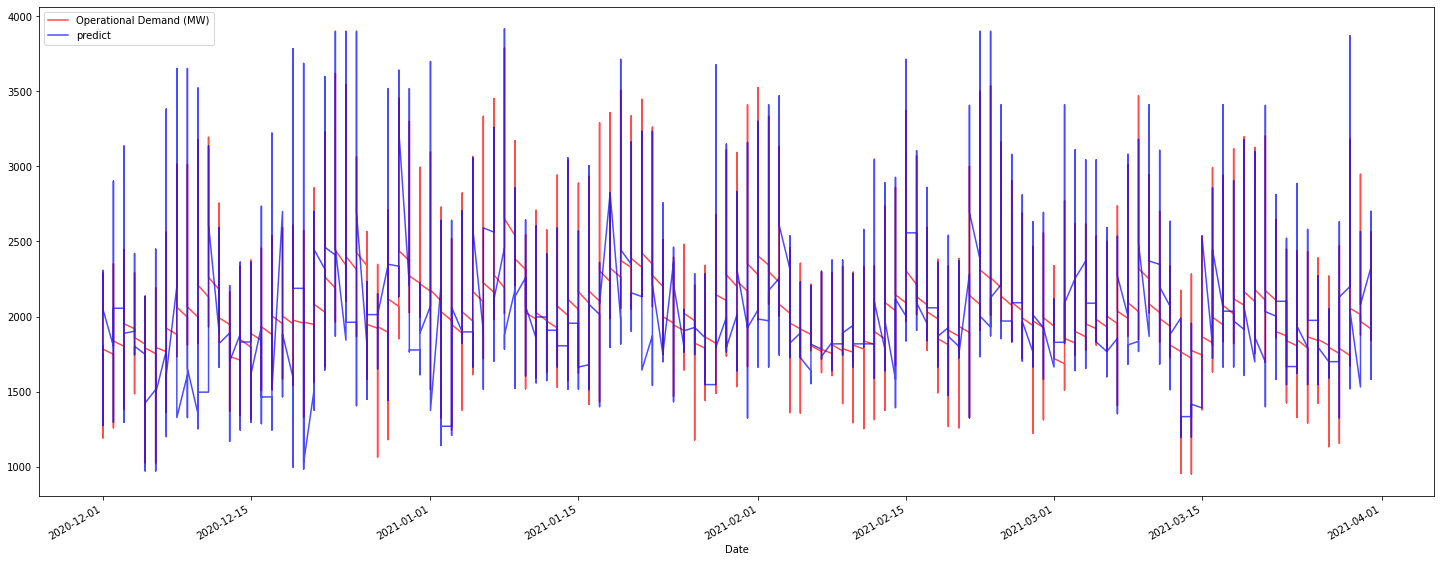

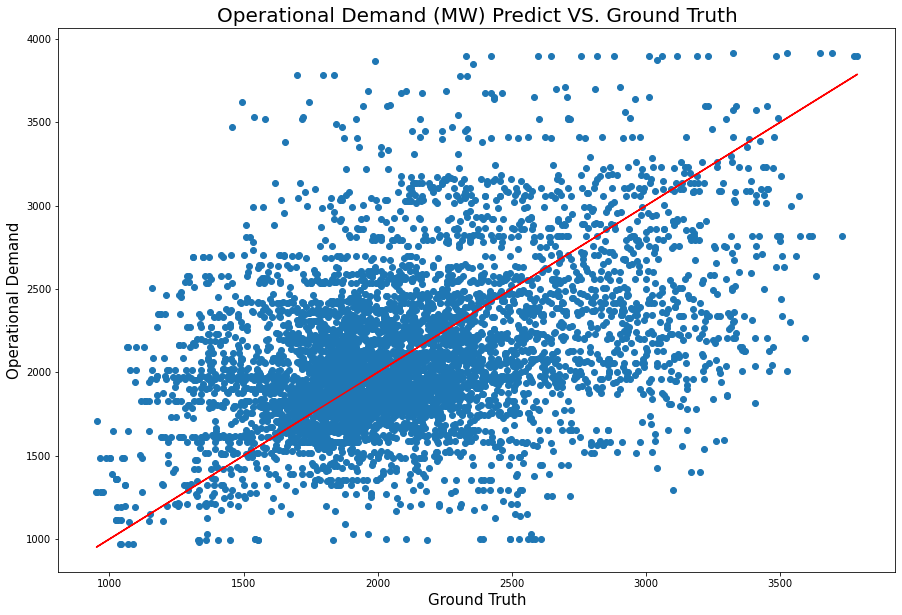

In [14]:
predict_table_tree.plot.line(figsize = (25,10), color = ['red','blue'],alpha = 0.7)
plt.show()
plt.figure(figsize=(15,10))
plt.scatter(predict_table_tree['Operational Demand (MW)'], predict_table_tree['predict'])
plt.plot(predict_table_tree['Operational Demand (MW)'],predict_table_tree['Operational Demand (MW)'], c= 'red')
plt.xlabel('Ground Truth',fontsize = 15)
plt.ylabel("Operational Demand", fontsize = 15)
plt.title("Operational Demand (MW) Predict VS. Ground Truth", fontsize = 20)
plt.show()

## Random Forest

In [15]:
forest = RandomForestRegressor(criterion='mse', 
                                max_depth=5, # depth of tree 
                                min_samples_leaf=10, 
                                random_state=42)

forest.fit(X_train, y_train)
y_predict_forest = forest.predict(X_test)
ny_test = len(y_test)
mape = (sum(np.abs((y_test - y_predict_forest)/y_test))/ny_test)*100
print('training mape', mape)

rfscore=ModelScore(y_test,y_predict_forest)
rfscore
ImportanceDisplay('forest')
# print(forest.best_estimator_)
# print(forest.best_score_)


training mape 14.804284006201081
Mean absolute error =  301.6171
Mean squared error =  153423.6729
Median absolute error =  231.536
explained variance error =  0.3104
R2 error =  0.3077
+----------------------+--------+
|       Factors        | Score  |
+----------------------+--------+
|     Day_of_week      | 0.4423 |
|   wind_speed(mph)    | 0.029  |
|     humidity(%)      | 0.0652 |
|    wind_gush(mph)    | 0.0077 |
|     pressure(in)     |  0.0   |
|        month         | 0.0059 |
|         year         | 0.1443 |
| temperature(celcius) | 0.0007 |
|     Day_of_year      | 0.2915 |
|         day          | 0.0118 |
|     Day_of_month     | 0.0008 |
|  dew_point(celcius)  | 0.0009 |
+----------------------+--------+


In [16]:
y_predict_forest = pd.DataFrame(y_predict_forest)
predict_table = pd.DataFrame(y_test)
predict_table.insert(1,'predict',y_predict_forest)
predict_table

,Operational Demand (MW),predict
Date,,
2020-12-01,1750.880,1860.060882
2020-12-01,1709.428,1860.060882
2020-12-01,1708.242,1860.060882
2020-12-01,1692.028,1860.060882
2020-12-01,1677.540,1860.060882
...,...,...
2021-03-31,2215.146,1982.894917
2021-03-31,2147.296,1982.894917
2021-03-31,2072.562,1982.894917


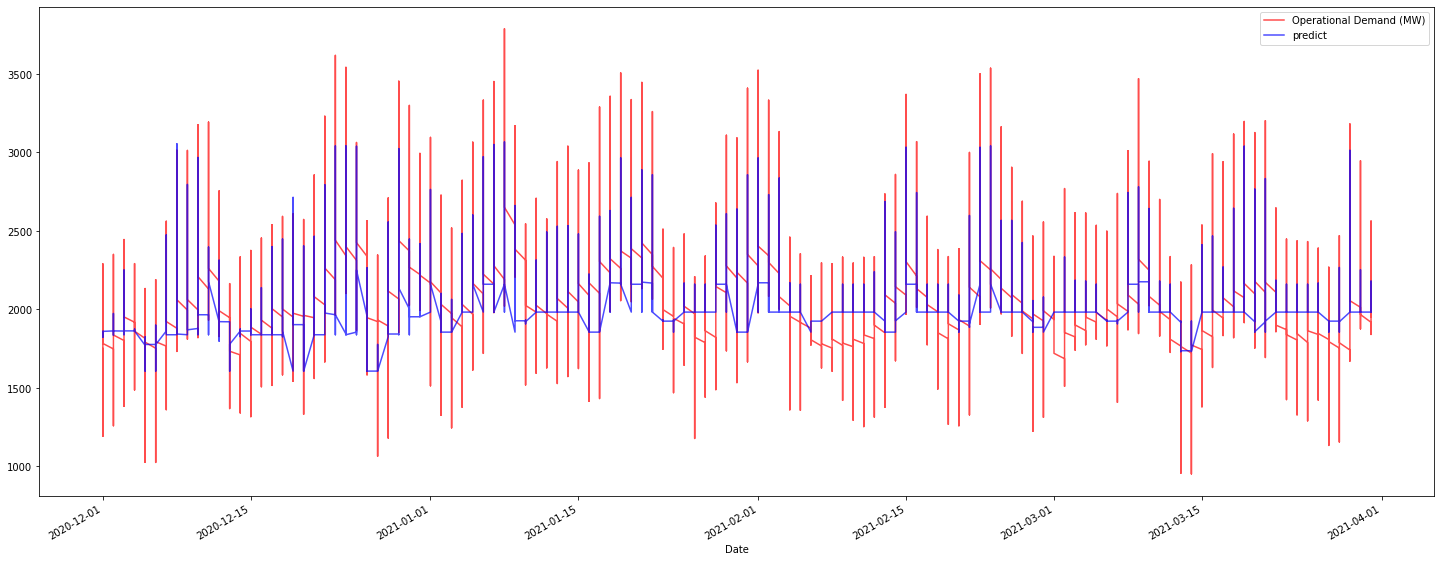

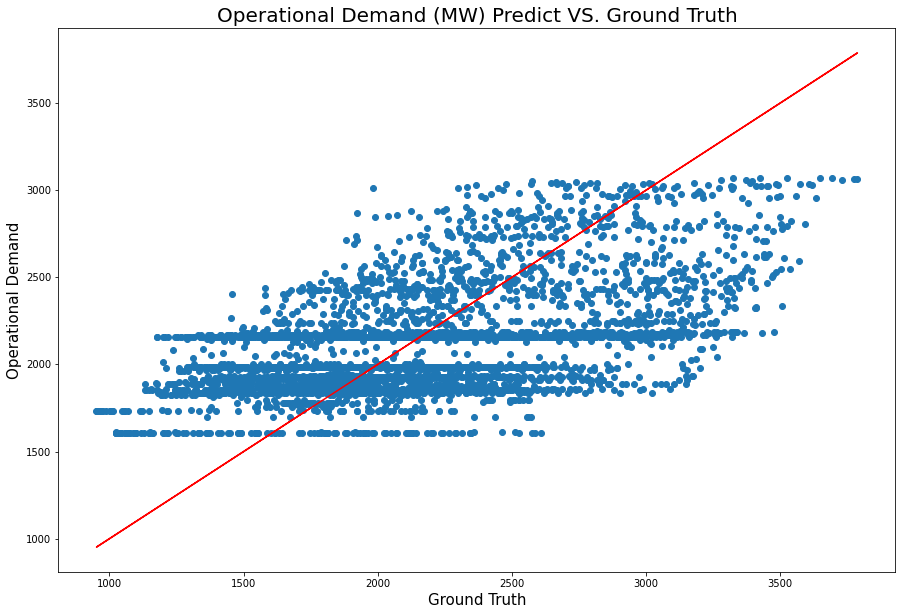

In [17]:
predict_table.plot.line(figsize = (25,10), color = ['red','blue'],alpha = 0.7)
plt.show()
plt.figure(figsize=(15,10))
plt.scatter(predict_table['Operational Demand (MW)'], predict_table['predict'])
plt.plot(predict_table['Operational Demand (MW)'],predict_table['Operational Demand (MW)'], c= 'red')
plt.xlabel('Ground Truth',fontsize = 15)
plt.ylabel("Operational Demand", fontsize = 15)
plt.title("Operational Demand (MW) Predict VS. Ground Truth", fontsize = 20)
plt.show()

In [26]:
order_table = predict_table.sort_values('Operational Demand (MW)',ascending=False)

In [27]:
order_table[:4]

,Operational Demand (MW),predict
Date,,
2021-01-08,3787.802,3061.693843
2021-01-08,3776.638,3061.693843
2021-01-08,3730.760,3057.499278
2021-01-08,3692.424,3067.167935
